# svg_dataset

> End-to-end functions taking in centerline-stroke SVG's and outputting deltas in Stroke-3 format.

In [ ]:
#| default_exp stroke3.path_joining

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
# |hide

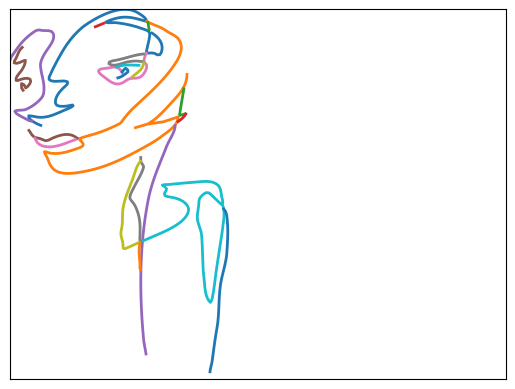

In [ ]:
from singleline_dataset.stroke3.path_transforms import svg_to_strokes
from singleline_dataset.stroke3.display_svg import *
from singleline_dataset.stroke3.display_plot import *
from IPython.display import SVG, display

rescaled_strokes = svg_to_strokes("../data/svg/0000.svg")

plot_strokes(rescaled_strokes)

In [ ]:
from singleline_dataset.stroke3.transforms import *
from singleline_dataset.stroke3.path_transforms import *


# available_endpoints = []

for s in rescaled_strokes:
    print(len(s))
    start = s[0]
    end = s[1]
    # #print(bb_rank2(s))
    # available_endpoints.append((start, s, 'END'))
    # available_endpoints.append((end, s, 'END'))


145
155
4
4
67
36
37
24
8
8
9
25
14
5
97
19
16
38
44
157
69
12


In [ ]:
#| export
import numpy as np


def closest_endpoint_pair(strokes):
    sorted_strokes = sorted(strokes, key=lambda s: len(s), reverse=True)

    min_dist = 1e10
    min_s_idx = None
    min_c_idx = None
    min_s_pos = None
    min_c_pos = None

    for i, s in enumerate(sorted_strokes):
        s_start = s[0]
        s_end = s[-1]
        for j, c in enumerate(sorted_strokes):
            if i==j:
                continue
            c_start = c[0]
            c_end = c[:1]

            ss_cs_dist = np.linalg.norm(s_start - c_start)
            ss_ce_dist = np.linalg.norm(s_start - c_end)
            se_cs_dist = np.linalg.norm(s_end - c_start)
            se_ce_dist = np.linalg.norm(s_end - c_end)

            # print(i, len(c), (ss_cs_dist, ss_ce_dist, se_cs_dist, se_ce_dist))

            if ss_cs_dist < min_dist:
                min_dist = ss_cs_dist
                min_s_idx = i
                min_c_idx = j
                min_s_pos = 'START'
                min_c_pos = 'START'
            if ss_ce_dist < min_dist:
                min_dist = ss_ce_dist
                min_s_idx = i
                min_c_idx = j
                min_s_pos = 'START'
                min_c_pos = 'END'
            if se_cs_dist < min_dist:
                min_dist = se_cs_dist
                min_s_idx = i
                min_c_idx = j
                min_s_pos = 'END'
                min_c_pos = 'START'
            if se_ce_dist < min_dist:
                min_dist = se_ce_dist
                min_s_idx = i
                min_c_idx = j
                min_s_pos = 'END'
                min_c_pos = 'END'
    return min_dist, min_s_idx, min_c_idx, min_s_pos, min_c_pos


def join_endpoints(strokes, min_s_idx, min_c_idx, min_s_pos, min_c_pos):
    starter = strokes[min_s_idx]
    joinee = strokes[min_c_idx]    
    remaining = [x for i, x in enumerate(strokes) if i not in [min_s_idx, min_c_idx]]
    print(f"sorted_strokes ({len(strokes)}), remaining ({len(remaining)})")

    joined = None
    if min_s_pos == "START":
        if min_c_pos == "START":
            joined = np.concatenate([np.flip(joinee, axis=0), starter], axis=0)
        elif min_c_pos == "END":
            joined = np.concatenate([joinee, starter], axis=0)
        else:
            raise Exception(f"invalid min_c_pos: {min_c_pos}")
    elif min_s_pos == "END":
        if min_c_pos == "START":
            joined = np.concatenate([starter, joinee], axis=0)
        elif min_c_pos == "END":
            joined = np.concatenate([starter, np.flip(joinee, axis=0)], axis=0)
        else:
            raise Exception(f"invalid min_c_pos: {min_c_pos}")
    else:
        raise Exception(f"invalid min_s_pos: {min_s_pos}")
    
    return [joined] + remaining


def merge_closest_strokes(strokes, dist_threshold=10.0):
    sorted_strokes = sorted(strokes, key=lambda s: len(s), reverse=True)

    min_dist, min_s_idx, min_c_idx, min_s_pos, min_c_pos = closest_endpoint_pair(sorted_strokes)
    
    print(f"Minimum distance: {min_dist}")
    print(f"From {min_s_idx}_{min_s_pos} ({len(strokes[min_s_idx])} points)")
    print(f"To {min_c_idx}_{min_c_pos} ({len(strokes[min_s_idx])} points)")

    if min_dist >= dist_threshold:
        print("not merging")
        return min_dist, strokes
    
    return min_dist, join_endpoints(sorted_strokes, min_s_idx, min_c_idx, min_s_pos, min_c_pos)
    

In [ ]:
import copy

def merge_until(strokes, dist_threshold=10.0):
    curr_strokes = copy.copy(strokes)
    all_iterations = [curr_strokes]
    for i in range(len(curr_strokes)):
        min_dist, curr_strokes = merge_closest_strokes(curr_strokes, dist_threshold=dist_threshold)
        print(f"[{i}] - len(curr_strokes) = {len(curr_strokes)}, min_dist = {min_dist}")
        if min_dist > dist_threshold:
            print("exceeded dist threshold")
            break
        all_iterations.append(curr_strokes)
    print(f"finished merging - len(curr_strokes) = {len(curr_strokes)}, min_dist = {min_dist}")
    return curr_strokes, all_iterations

In [ ]:
r0, r_iter = merge_until(rescaled_strokes, dist_threshold=10)
len(r0), [len(r) for r in r_iter]

Minimum distance: 0.40342377522616846
From 14_END (97 points)
To 19_START (97 points)
sorted_strokes (22), remaining (20)
[0] - len(curr_strokes) = 21, min_dist = 0.40342377522616846
Minimum distance: 0.5023185486414509
From 6_END (67 points)
To 15_START (67 points)
sorted_strokes (21), remaining (19)
[1] - len(curr_strokes) = 20, min_dist = 0.5023185486414509
Minimum distance: 0.5138644417789598
From 11_START (24 points)
To 16_START (24 points)
sorted_strokes (20), remaining (18)
[2] - len(curr_strokes) = 19, min_dist = 0.5138644417789598
Minimum distance: 0.5492710411450011
From 8_END (38 points)
To 15_START (38 points)
sorted_strokes (19), remaining (17)
[3] - len(curr_strokes) = 18, min_dist = 0.5492710411450011
Minimum distance: 0.6894214938226391
From 1_START (157 points)
To 16_START (157 points)
sorted_strokes (18), remaining (16)
[4] - len(curr_strokes) = 17, min_dist = 0.6894214938226391
Minimum distance: 0.7294996802981244
From 8_END (38 points)
To 1_START (38 points)
sorted_

(5, [22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5])

In [ ]:
def 

In [ ]:
len(rescaled_strokes)

22

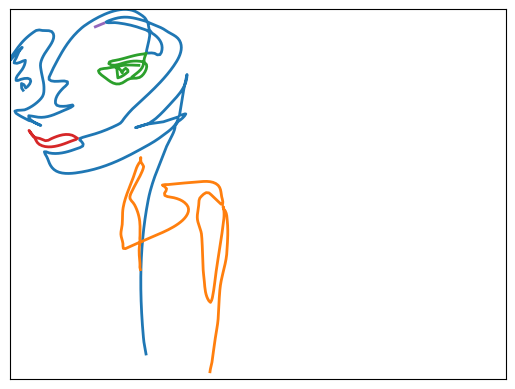

In [ ]:
plot_strokes(r0)

In [ ]:
strokes[[0, 5]][1].shape

(36, 2)

array([[  5.39224878,  44.65315115],
       [  4.81131888,  43.53006871],
       [  4.73205762,  42.25720444],
       ...,
       [ 55.60426993, 187.54991267],
       [ 55.78418586, 188.86874839],
       [ 55.94341456, 190.18882592]])

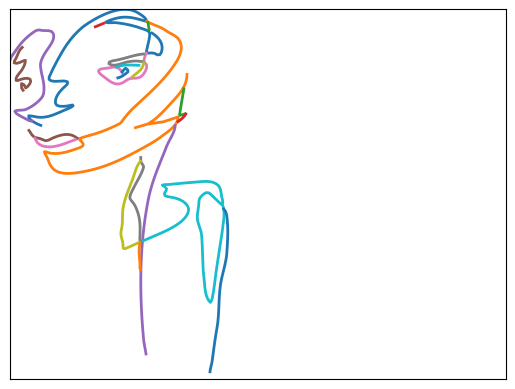

In [ ]:
plot_strokes(rescaled_strokes)

In [ ]:
#| hide
import nbdev

nbdev.nbdev_export()